In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from math import sqrt
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn import datasets
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

from imblearn.over_sampling import SMOTE

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
import re
import twitter

%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Build and document a working model, prototype, recommendation, or solution

[The Essential NLP Guide for Data Scientists (with codes for top 10 common NLP tasks)](https://www.analyticsvidhya.com/blog/2017/10/essential-nlp-guide-data-scientists-top-10-nlp-tasks/)

### NLP Text Classification using Twitter API

### Goals

Classify whether a tweet comes from Donald Trump or Nancy Pelosi -> Can we correctly identify which of these two politicians tweeted what?

Steps:
- Create a developer account on Twitter
- Create a method to pull a list of tweets from the Twitter API
- Perform proper preprocessing on our text
- Engineer sentiment feature in our dataset using TextBlob
- Explore supervised classification techniques

### Twitter API Developer Registration

- Register for a Twitter account -> requirement in order to have a "developer" account.

  [Twitter Rest API](https://dev.twitter.com/rest/public)

### Create an "App"

- Register an "app" on Twitter ([apps.twitter.com](https://apps.twitter.com/)).

- **Note**: A placeholder can be used for the required website field (e.g., https://www.placeholder.com).

- Reference the corresponding keys and tokens that Twitter generates after setting up the app.

- These keys/tokens will be used with the app to communicate with the Twitter API.

### Install Python Twitter API Library

Python Twitter Library provided by [Python Twitter Tools](http://mike.verdone.ca/twitter/).

In [2]:
#$ pip install python-twitter

### App Keys and Tokens

Take note of the app consumer API keys and access tokens that will be used to connect to Twitter and mine tweets from the official Twitter accounts of Donald Trump and Nancy Pelosi

### Twitter API Key Setup

Fill in the information below with the keys from account.

- **consumer_key** - Found in the app page under the "Keys and tokens": (API key)
- **consumer_secret** - Under **consumer_key** in the "Keys and tokens" tab: (API secret key)
- **access_token_key** - Click the button to generate access token: (Access token)
- **access_token_secret** - Under **access_token_key**: (Access token secret)

In [3]:
#import twitter, datetime

#### NOTE: EXCLUDING KEYS AND SECRETS FOR SECURITY PURPOSES

In [4]:
twitter_keys = {'consumer_key':        '',
                'consumer_secret':     '',
                'access_token_key':    '',
                'access_token_secret': ''}

api = twitter.Api(consumer_key         =   twitter_keys['consumer_key'],
                  consumer_secret      =   twitter_keys['consumer_secret'],
                  access_token_key     =   twitter_keys['access_token_key'],
                  access_token_secret  =   twitter_keys['access_token_secret'])

### `TweetMiner` class structure

The following code will provide connectivity to Twitter. The class has the ability to make requests and can eventually transform the JSON responses into DataFrames.

**Note:** "result_limit" is used to limit the number of tweets that are pulled per instance request.  Setting it to a lower value until the bugs are worked out of the request, and captured the data wanted, is essential to avoiding the rate limit blocks.

In [5]:
class TweetMiner(object):

    result_limit    =   20    
    api             =   False
    data            =   []
    
    twitter_keys = {'consumer_key':        '',
                    'consumer_secret':     '',
                    'access_token_key':    '',
                    'access_token_secret': ''}
    
    def __init__(self, keys_dict, api, result_limit=20):
        
        self.api = api
        self.twitter_keys = keys_dict
        self.result_limit = result_limit
        
    def mine_user_tweets(self, user='TWeichle', mine_retweets=False, max_pages=5):

        data           =  []
        last_tweet_id  =  False
        page           =  1
        
        while page <= max_pages:
            
            if last_tweet_id:
                statuses = self.api.GetUserTimeline(screen_name=user, count=self.result_limit, max_id=last_tweet_id-1)        
            else:
                statuses = self.api.GetUserTimeline(screen_name=user, count=self.result_limit)
                
            for item in statuses:

                mined = {'tweet_id':        item.id,
                         'handle':          item.user.name,
                         'retweet_count':   item.retweet_count,
                         'text':            item.text,
                         'mined_at':        datetime.now(),
                         'created_at':      item.created_at}
                
                last_tweet_id = item.id
                data.append(mined)
                
            page += 1
            
        return data

### Creating Data
"Mine" data from the Twitter API.

1. Mine Trump tweets
- Create a Trump tweet DataFrame
- Mine Pelosi tweets
- Create a Pelosi tweet DataFrame
- Append Trump and Pelosi tweet DataFrames

In [6]:
# Instantiate a TweetMiner class
# -> Pass the 'twitter_keys' dictionary and api as arguments
#miner = TweetMiner(twitter_keys, api, result_limit=2)
miner = TweetMiner(twitter_keys, api, result_limit=400)

Call the TweetMiner's `mine_user_tweets()` method, providing twitter handles to pull the tweets.

In [7]:
# Mine Trump tweets
#trump_tweets = miner.mine_user_tweets(user='realDonaldTrump', max_pages=5)
trump_tweets = miner.mine_user_tweets(user='realDonaldTrump')

In [8]:
# Count number of items in list
len(trump_tweets)

1000

In [9]:
# Display first item in list
trump_tweets[0]

{'tweet_id': 1111044654223552513,
 'handle': 'Donald J. Trump',
 'retweet_count': 4436,
 'text': 'https://t.co/lGxIGgf43F',
 'mined_at': datetime.datetime(2019, 3, 27, 16, 48, 28, 916553),
 'created_at': 'Wed Mar 27 23:17:42 +0000 2019'}

In [10]:
# Create tweet DataFrame
trump_df = pd.DataFrame(trump_tweets)

In [11]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(trump_df.shape[0], trump_df.shape[1]))

Rows: 1000, Cols: 6


In [12]:
# Mine Pelosi tweets
#pelosi_tweets = miner.mine_user_tweets(user='SpeakerPelosi', max_pages=5)
pelosi_tweets = miner.mine_user_tweets('SpeakerPelosi')

In [13]:
# Count number of items in list
len(pelosi_tweets)

1000

In [14]:
# Display first item in list
pelosi_tweets[0]

{'tweet_id': 1111050874204422144,
 'handle': 'Nancy Pelosi',
 'retweet_count': 222,
 'text': 'Over the course of her working life, the average American woman loses $400,000 to the wage gap. Today, the House to… https://t.co/nBqMTL800o',
 'mined_at': datetime.datetime(2019, 3, 27, 16, 48, 30, 626849),
 'created_at': 'Wed Mar 27 23:42:25 +0000 2019'}

In [15]:
# Create tweet DataFrame
pelosi_df = pd.DataFrame(pelosi_tweets)

In [16]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(pelosi_df.shape[0], pelosi_df.shape[1]))

Rows: 1000, Cols: 6


In [17]:
# Concatenate DataFrames
# Note: axis=0 for rows, axis=1 for columns
#       ignore_index=False
tweets = pd.concat([trump_df, pelosi_df], axis=0, ignore_index=True)

### Examine the DataFrame

In [18]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(tweets.shape[0], tweets.shape[1]))

Rows: 2000, Cols: 6


In [19]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 6 columns):
created_at       2000 non-null object
handle           2000 non-null object
mined_at         2000 non-null datetime64[ns]
retweet_count    2000 non-null int64
text             2000 non-null object
tweet_id         2000 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 93.8+ KB


In [20]:
# Print the first 5 rows and the last 5 rows of the DataFrame
tweets.head().append(tweets.tail())

,created_at,handle,mined_at,retweet_count,text,tweet_id
0,Wed Mar 27 23:17:42 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916553,4436,https://t.co/lGxIGgf43F,1111044654223552513
1,Wed Mar 27 21:30:32 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916560,5673,RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: O...,1111017686987956227
2,Wed Mar 27 20:48:47 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916562,9636,We are here today to award America’s highest m...,1111007177190375424
3,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916563,7783,....Also discussed political fairness and vari...,1110989595758469120
4,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916564,9737,"Just met with @SundarPichai, President of @Goo...",1110989594521026561
1995,Wed Jun 20 12:22:15 +0000 2018,Nancy Pelosi,2019-03-27 16:48:31.930454,642,RT @RepJohnYarmuth: Today @HouseBudgetGOP are ...,1009411100712960002
1996,Tue Jun 19 18:47:04 +0000 2018,Nancy Pelosi,2019-03-27 16:48:31.930456,201,Wishing everyone a very happy #Juneteenth2018!...,1009145559012306944
1997,Tue Jun 19 18:08:02 +0000 2018,Nancy Pelosi,2019-03-27 16:48:31.930457,318,"All Americans must ask, why do Republicans bel...",1009135735985917952
1998,Tue Jun 19 18:08:02 +0000 2018,Nancy Pelosi,2019-03-27 16:48:31.930458,272,The atrocity of family separation is not about...,1009135734912151552
1999,Tue Jun 19 18:08:02 +0000 2018,Nancy Pelosi,2019-03-27 16:48:31.930459,1251,Every day that Congressional Republicans allow...,1009135734081703936


#### TextBlob: Simplified Text Processing
[TextBlob](https://textblob.readthedocs.io/en/dev/) is a Python library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

In [21]:
# Print the second tweet
print(tweets.text[1])

RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: One-on-one with @realdonaldtrump — the President’s first interview since Mueller found no coll…


In [22]:
# A general text block, meant for larger bodies of text (especially those containing sentences)
tweet_1 = TextBlob(tweets.text.values[1])

In [23]:
# A list-like collection of words
tweet_1.words

WordList(['RT', 'seanhannity', 'HANNITY', 'EXCLUSIVE', 'TONIGHT', 'One-on-one', 'with', 'realdonaldtrump', '—', 'the', 'President', '’', 's', 'first', 'interview', 'since', 'Mueller', 'found', 'no', 'coll…'])

In [24]:
# A list-like collection of sentences
tweet_1.sentences

[Sentence("RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: One-on-one with @realdonaldtrump — the President’s first interview since Mueller found no coll…")]

In [25]:
# Returns new object with all lower-cased characters
tweet_1.lower()

TextBlob("rt @seanhannity: #hannity exclusive tonight: one-on-one with @realdonaldtrump — the president’s first interview since mueller found no coll…")

### Handling Missing Values

In [26]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
tweets.isnull().sum()

created_at       0
handle           0
mined_at         0
retweet_count    0
text             0
tweet_id         0
dtype: int64

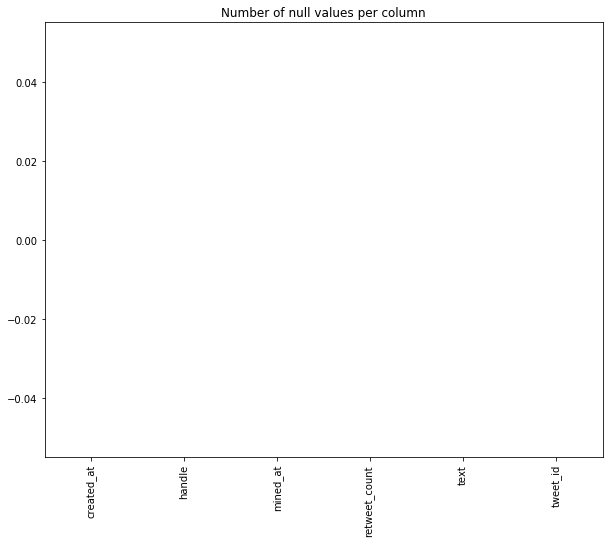

In [27]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
tweets.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

### Summarize the DataFrame

In [28]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
tweets.describe()

,retweet_count,tweet_id
count,2000.000000,2.000000e+03
mean,13373.082500,1.078043e+18
std,13660.242065,2.982935e+16
min,17.000000,1.009136e+18
25%,1110.500000,1.061661e+18
50%,9559.000000,1.087151e+18
75%,22656.000000,1.101193e+18
max,95596.000000,1.111051e+18


In [29]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
tweets.describe(include='object')

,created_at,handle,text
count,2000,2000,2000
unique,1937,2,1995
top,Sat Dec 22 14:44:28 +0000 2018,Donald J. Trump,MAKE AMERICA GREAT AGAIN!
freq,4,1000,5


In [30]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
tweets.handle.value_counts()

Donald J. Trump    1000
Nancy Pelosi       1000
Name: handle, dtype: int64

#### Create indicator for whether a tweet was from Donald Trump

In [31]:
# Lambda function: apply an arbitrary function to each value of a Pandas column, storing the result in a new column
tweets['trump_handle'] = tweets.handle.apply(lambda handle: 1 if handle == 'Donald J. Trump' else 0)

### Any interesting n-grams for Donald Trump?

- Set up a vectorizer from sklearn
- Fit the text of Trump's tweets with an n-gram range from 2 to 4
- Determine the most common n-grams

**Note:** How does keeping or removing stopwords affect the results?

Keeping stopwords will result in many more common n-grams containing stop words -> REMOVE STOPWORDS

In [32]:
# Instantiate TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features
# -> Equivalent to CountVectorizer followed by TfidfTransformer
# Note: stop_words: if a string, it is passed to _check_stop_list and the appropriate stop list is returned;
#                   'english' is currently the only supported string value
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
vect = TfidfVectorizer(stop_words='english', ngram_range=(2, 4))

In [33]:
# Pulls all of Trump's tweet texts into one giant string
summaries = "".join(trump_df.text)

# Return a callable that handles preprocessing and tokenization
ngrams_summaries = vect.build_analyzer()(summaries)

# Dict subclass for counting hashable items; sometimes called a bag or multiset
# -> Elements are stored as dictionary keys and their counts are stored as dictionary values
# 20 most common elements
Counter(ngrams_summaries).most_common(20)

[('border security', 35),
 ('fake news', 31),
 ('president trump', 25),
 ('united states', 24),
 ('southern border', 24),
 ('rt realdonaldtrump', 17),
 ('rt whitehouse', 15),
 ('america great', 12),
 ('rt gopchairwoman', 11),
 ('michael cohen', 11),
 ('border https', 11),
 ('kim jong', 11),
 ('news media', 10),
 ('approval rating', 10),
 ('north korea', 10),
 ('fake news media', 10),
 ('great people', 9),
 ('security wall', 9),
 ('rt paulsperry_', 9),
 ('new book', 9)]

### Any interesting n-grams for Nancy Pelosi?

In [34]:
# Instantiate TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features
# -> Equivalent to CountVectorizer followed by TfidfTransformer
# Note: stop_words: if a string, it is passed to _check_stop_list and the appropriate stop list is returned;
#                   'english' is currently the only supported string value
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
vect = TfidfVectorizer(stop_words='english', ngram_range=(2, 4))

In [35]:
# Pulls all of Trump's tweet texts into one giant string
summaries = "".join(pelosi_df.text)

# Return a callable that handles preprocessing and tokenization
ngrams_summaries = vect.build_analyzer()(summaries)

# Dict subclass for counting hashable items; sometimes called a bag or multiset
# -> Elements are stored as dictionary keys and their counts are stored as dictionary values
# 20 most common elements
Counter(ngrams_summaries).most_common(20)

[('health care', 31),
 ('pre existing', 30),
 ('trump admin', 22),
 ('american people', 20),
 ('speaking reporters', 20),
 ('live capitol', 19),
 ('trump administration', 17),
 ('existing conditions', 17),
 ('pre existing conditions', 17),
 ('reporters live', 16),
 ('tune https', 16),
 ('reporters live capitol', 16),
 ('working families', 15),
 ('supreme court', 15),
 ('amp https', 14),
 ('forthepeople act', 12),
 ('speaking reporters live', 12),
 ('speaking reporters live capitol', 12),
 ('press conference', 11),
 ('10 45', 10)]

### Sentiment Analysis

Understanding how positive or negative a document (piece of text) is. There are many ways in practice to compute a sentiment value. For example:
- Have a list of "positive" words and a list of "negative" words and count how many occur in a document. 
- Train a classifier given many examples of "positive" documents and "negative" documents. 
    - Note that this technique is often just an automated way to derive the first (e.g., using bag-of-words with logistic regression, a coefficient is assigned to each word!).

For the most accurate sentiment analysis, train a custom sentiment model based on documents that are particular to the application. Generic models often do not work as well as hoped.

Always make sure to double-check that the algorithm is working by manually verifying that scores correctly correspond to positive/negative reviews! Otherwise, you may be using numbers that are not accurate.

#### Extract sentiment from a tweet parsed with TextBlob

In [36]:
print(tweet_1)

RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: One-on-one with @realdonaldtrump — the President’s first interview since Mueller found no coll…


In [37]:
# Polarity ranges from -1 (most negative) to 1 (most positive)
print('Sentiment Polarity:', round(tweet_1.sentiment.polarity, 3))

Sentiment Polarity: 0.25


#### Calculate the sentiment for every tweet in the full tweets dataset as a new column

In [38]:
# Define a function that accepts text and returns the polarity
# -> Polarity ranges from -1 (most negative) to 1 (most positive)
def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [39]:
# Create a new DataFrame column for sentiment (Warning: SLOW!)
tweets['sentiment'] = tweets.text.apply(detect_sentiment)
tweets.head(5)

,created_at,handle,mined_at,retweet_count,text,tweet_id,trump_handle,sentiment
0,Wed Mar 27 23:17:42 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916553,4436,https://t.co/lGxIGgf43F,1111044654223552513,1,0.000000
1,Wed Mar 27 21:30:32 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916560,5673,RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: O...,1111017686987956227,1,0.250000
2,Wed Mar 27 20:48:47 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916562,9636,We are here today to award America’s highest m...,1111007177190375424,1,-0.100000
3,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916563,7783,....Also discussed political fairness and vari...,1110989595758469120,1,0.083333
4,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916564,9737,"Just met with @SundarPichai, President of @Goo...",1110989594521026561,1,0.216667


#### Box plot of sentiment grouped by handle

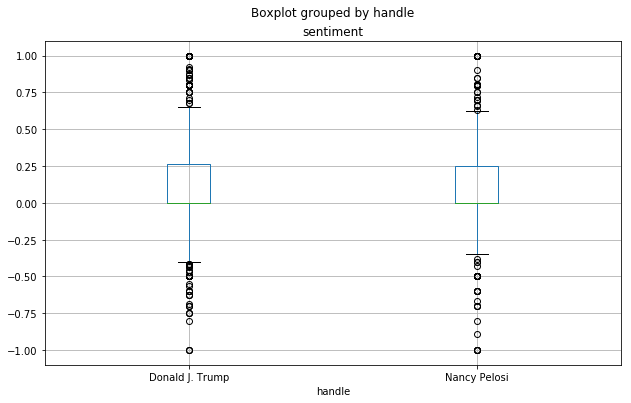

In [40]:
# Create box plots
# Note: column: used to limit data to a subset of columns
#       by: used to form box plots for separate groups
#       figsize: a tuple (width, height) in inches
tweets.boxplot(column='sentiment', by='handle', figsize=(10, 6));

In [41]:
# Tweets with most positive sentiment
tweets[tweets.sentiment == 1][['handle', 'text', 'sentiment']].head()

,handle,text,sentiment
22,Donald J. Trump,A team of great champions! https://t.co/Pm5p9L...,1.0
31,Donald J. Trump,RT @realDonaldTrump: MAKE AMERICA GREAT AGAIN!,1.0
36,Donald J. Trump,MAKE AMERICA GREAT AGAIN!,1.0
47,Donald J. Trump,"3.1 GDP FOR THE YEAR, BEST NUMBER IN 14 YEARS!",1.0
62,Donald J. Trump,Really beautiful to see! https://t.co/DKq2TIeiSs,1.0


In [42]:
# Reviews with most negative sentiment
tweets[tweets.sentiment == -1][['handle', 'text', 'sentiment']].head()

,handle,text,sentiment
41,Donald J. Trump,"....There is nothing to admire about them, the...",-1.0
496,Donald J. Trump,"One year ago today, a horrific act of violence...",-1.0
979,Donald J. Trump,Any deaths of children or others at the Border...,-1.0
1082,Nancy Pelosi,".@realDonaldTrump’s revival of his bigoted, di...",-1.0
1093,Nancy Pelosi,The #TrumpBudget is a cruel roadmap to a sicke...,-1.0


In [43]:
# Widen the column display
pd.set_option('max_colwidth', 500)

In [44]:
# Negative sentiment in a Trump tweet
tweets[(tweets.handle == 'Donald J. Trump') & (tweets.sentiment < -0.3)].head(1)

,created_at,handle,mined_at,retweet_count,text,tweet_id,trump_handle,sentiment
13,Tue Mar 26 20:36:53 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916577,18041,“A Catastrophic Media Failure” https://t.co/dkHo5kHwwf,1110641794621018112,1,-0.316667


In [45]:
# Positive sentiment in a Pelosi tweet
tweets[(tweets.handle == 'Nancy Pelosi') & (tweets.sentiment > 0.5)].head(1)

,created_at,handle,mined_at,retweet_count,text,tweet_id,trump_handle,sentiment
1012,Tue Mar 26 18:59:49 +0000 2019,Nancy Pelosi,2019-03-27 16:48:30.626870,739,"RT @RepShalala: Proud to stand with @SpeakerPelosi and @HouseDemocrats as we introduce legislation to protect Americans from junk plans, st…",1110617367330148353,0,0.8


In [46]:
# Reset the column display width
pd.reset_option('max_colwidth')

### Data Modeling

### Using NLP Text Classification

#### Build and train text classification models

### Text Preprocessing

Note: There are website links in the tweets.<br>
Using the textacy package to do more comprehensive preprocessing before building model
(http://textacy.readthedocs.io/en/latest/).

In [47]:
tweet_text = tweets.text.values

# Normalize various aspects of a raw text doc before parsing it with Spacy
# -> A convenience function for applying all other preprocessing functions in one go
# Note: fix_unicode: if True, fix "broken" unicode such as mojibake and garbled HTML entities
#       lowercase: if True, all text is lower-cased
#       transliterate: if True, convert non-ascii characters into their closest ascii equivalents
#       no_urls: if True, replace all URL strings with '*URL*'
#       no_emails: if True, replace all email strings with '*EMAIL*'
#       no_phone_numbers: if True, replace all phone number strings with '*PHONE*'
#       no_currency_symbols: if True, replace all currency symbols with their standard 3-letter abbreviations
#       no_punct: if True, remove all punctuation (replace with empty string)
#       no_accents: if True, replace all accented characters with unaccented versions; NB: if `transliterate` is True, this option is redundant
clean_text = [preprocess_text(x, fix_unicode=True, lowercase=True, transliterate=False,
                              no_urls=True, no_emails=True, no_phone_numbers=True, no_currency_symbols=True,
                              no_punct=True, no_accents=True)
              for x in tweet_text]

In [48]:
print(tweet_text[0:3])

['https://t.co/lGxIGgf43F'
 'RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: One-on-one with @realdonaldtrump — the President’s first interview since Mueller found no coll…'
 'We are here today to award America’s highest military honor to a fallen hero who made the supreme sacrifice for our… https://t.co/LDPHbphb1g']


In [49]:
print(clean_text[0:3])

['url', 'rt seanhannity hannity exclusive tonight one on one with realdonaldtrump the president s first interview since mueller found no coll', 'we are here today to award america s highest military honor to a fallen hero who made the supreme sacrifice for our url']


In [50]:
# Create a DataFrame from a list
clean_text_df = pd.DataFrame(clean_text, columns=['clean_text'])

In [51]:
# Concatenate DataFrames
# Note: axis=0 for rows, axis=1 for columns
tweets = pd.concat([tweets, clean_text_df], axis=1)
tweets.head()

,created_at,handle,mined_at,retweet_count,text,tweet_id,trump_handle,sentiment,clean_text
0,Wed Mar 27 23:17:42 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916553,4436,https://t.co/lGxIGgf43F,1111044654223552513,1,0.000000,url
1,Wed Mar 27 21:30:32 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916560,5673,RT @seanhannity: #HANNITY EXCLUSIVE TONIGHT: O...,1111017686987956227,1,0.250000,rt seanhannity hannity exclusive tonight one o...
2,Wed Mar 27 20:48:47 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916562,9636,We are here today to award America’s highest m...,1111007177190375424,1,-0.100000,we are here today to award america s highest m...
3,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916563,7783,....Also discussed political fairness and vari...,1110989595758469120,1,0.083333,also discussed political fairness and various ...
4,Wed Mar 27 19:38:55 +0000 2019,Donald J. Trump,2019-03-27 16:48:28.916564,9737,"Just met with @SundarPichai, President of @Goo...",1110989594521026561,1,0.216667,just met with sundarpichai president of google...


### Building Phase

#### Predicting Donald Trump tweets

In [52]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(tweets.trump_handle.value_counts(dropna=False))
print()
print('Percentage of trump_handle=No(0), trump_handle=Yes(1)')
round(tweets.trump_handle.value_counts(dropna=False)/len(tweets), 3)

1    1000
0    1000
Name: trump_handle, dtype: int64

Percentage of trump_handle=No(0), trump_handle=Yes(1)


1    0.5
0    0.5
Name: trump_handle, dtype: float64

Note: CLASSES ARE EQUALLY BALANCED!!

In [53]:
# Create a list of features
feature_cols = ['clean_text', 'sentiment']

# Create X and y
X = tweets[feature_cols]
y = tweets.trump_handle

In [54]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

#### Compute Baseline Accuracy
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

In [55]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
print(y_train.value_counts())
print()

most_freq_class = y_train.value_counts().index[0]
print('Most frequent class in training dataset:', most_freq_class)
print()

print('Baseline accuracy:', round(y_test.value_counts()[most_freq_class] / y_test.count(), 3))

0    710
1    690
Name: trump_handle, dtype: int64

Most frequent class in training dataset: 0

Baseline accuracy: 0.483


### Text Processing

[CountVectorizer documentation](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

Use CountVectorizer with text column only.

In [56]:
# Instantiate CountVectorizer to convert a collection of text documents to a matrix of token counts
# -> This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix
vect = CountVectorizer()

# Learn the vocabulary dictionary and return term-document matrix
# -> This is equivalent to fit followed by transform, but more efficiently implemented
X_train_dtm = vect.fit_transform(X_train.clean_text)

# Transform documents to document-term matrix
# -> Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor
X_test_dtm = vect.transform(X_test.clean_text)

In [57]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_train_dtm.shape[0], X_train_dtm.shape[1]))

Rows: 1400, Cols: 4531


In [58]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_test_dtm.shape[0], X_test_dtm.shape[1]))

Rows: 600, Cols: 4531


Shape of other feature columns.

In [59]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_train.drop('clean_text', axis=1).shape[0], X_train.drop('clean_text', axis=1).shape[1]))

Rows: 1400, Cols: 1


In [60]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_test.drop('clean_text', axis=1).shape[0], X_test.drop('clean_text', axis=1).shape[1]))

Rows: 600, Cols: 1


Training set:<br>Cast other feature columns to float and convert to a sparse matrix

In [61]:
# Compressed Sparse Row matrix
extra = sp.sparse.csr_matrix(X_train.drop('clean_text', axis=1).astype(float))
extra

<1400x1 sparse matrix of type '<class 'numpy.float64'>'
	with 871 stored elements in Compressed Sparse Row format>

In [62]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(extra.shape[0], extra.shape[1]))

Rows: 1400, Cols: 1


In [63]:
# Combine sparse matrices
# -> Stack sparse matrices horizontally (column wise)
X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))

# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_train_dtm_extra.shape[0], X_train_dtm_extra.shape[1]))

Rows: 1400, Cols: 4532


Testing set:<br>Cast other feature columns to float and convert to a sparse matrix

In [64]:
# Compressed Sparse Row matrix
extra = sp.sparse.csr_matrix(X_test.drop('clean_text', axis=1).astype(float))
extra

<600x1 sparse matrix of type '<class 'numpy.float64'>'
	with 365 stored elements in Compressed Sparse Row format>

In [65]:
# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(extra.shape[0], extra.shape[1]))

Rows: 600, Cols: 1


In [66]:
# Combine sparse matrices
# -> Stack sparse matrices horizontally (column wise)
X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))

# Return the number of rows (documents) and columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Rows: {}, Cols: {}'.format(X_test_dtm_extra.shape[0], X_test_dtm_extra.shape[1]))

Rows: 600, Cols: 4532


In [67]:
# Get parameters for this estimator
vect.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [68]:
# Array mapping from feature integer indices to feature name
# -> Last 50 features
print(vect.get_feature_names()[-50:])

['words', 'work', 'worked', 'worker', 'workers', 'workforce', 'workin', 'working', 'works', 'world', 'worldwide', 'worry', 'worse', 'worst', 'worth', 'would', 'wouldn', 'wounded', 'wow', 'write', 'writes', 'writing', 'written', 'wrong', 'wrote', 'wsj', 'xi', 'xia', 'ye', 'year', 'yearly', 'years', 'yemen', 'yes', 'yesterday', 'yet', 'york', 'you', 'young', 'your', 'yourself', 'youtube', 'yrs', 'yubucoa', 'yum', 'zacharyivanpor1', 'zealand', 'zero', 'zinke', 'zte']


In [69]:
# 'vocabulary_' is a dictionary that converts each word to its index in the sparse matrix
print('Number of features (unique words):', len(vect.vocabulary_))
vect.vocabulary_

Number of features (unique words): 4531


{'the': 4018,
 'democrats': 1109,
 'are': 341,
 'border': 533,
 'deniers': 1113,
 'they': 4029,
 'refuse': 3212,
 'to': 4083,
 'see': 3570,
 'or': 2787,
 'acknowledge': 140,
 'death': 1050,
 'crime': 975,
 'drugs': 1264,
 'and': 286,
 'human': 1955,
 'trafficking': 4119,
 'at': 377,
 'our': 2801,
 'southern': 3744,
 'rt': 3467,
 'repmaloney': 3326,
 'roevwade': 3447,
 'settled': 3641,
 'law': 2308,
 'protects': 3091,
 'women': 4473,
 'essential': 1395,
 'rights': 3431,
 'privacy': 3040,
 'healthcare': 1836,
 'reproductive': 3350,
 'freedom': 1640,
 'choice': 721,
 'that': 4017,
 'is': 2132,
 'trumpbudget': 4164,
 'cruel': 993,
 'roadmap': 3437,
 'sicker': 3683,
 'weaker': 4389,
 'america': 272,
 'americans': 276,
 'deserve': 1124,
 'federal': 1521,
 'budget': 580,
 'works': 4489,
 'url': 4250,
 'repescobar': 3300,
 'proud': 3094,
 'stand': 3789,
 'with': 4466,
 'my': 2626,
 'fellow': 1528,
 'housedemocrats': 1934,
 'introduce': 2104,
 'protecting': 3086,
 'pre': 2998,
 'existing': 1441

Multinomial Naive Bayes classifier (text features only with non-negative values)
- Note: MultinomialNB does not accept negative values (i.e., sentiment feature)

In [70]:
# Instantiate a Naive Bayes classifier for multinomial models and fit Naive Bayes classifier according to X, y
mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)

# Predict the class using the Multinomial Naive Bayes classifier
y_pred_class = mnb.predict(X_test_dtm)

# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Testing accuracy score: 0.873


Gaussian Naive Bayes classifier (text features and additional features which may include negative values)

In [71]:
# Instantiate a Gaussian Naive Bayes classifier and fit Gaussian Naive Bayes classifier according to X, y
gnb = GaussianNB()
gnb.fit(X_train_dtm_extra.toarray(), y_train)
    
# Predict the class using the Gaussian Naive Bayes classifier
y_pred_class = gnb.predict(X_test_dtm_extra.toarray())
    
# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Testing accuracy score: 0.858


Logistic Regression classifier (text features and additional features which may include negative values)

In [72]:
# Instantiate a Logistic Regression classifier and fit logistic model
logreg = LogisticRegression()
logreg.fit(X_train_dtm_extra, y_train)  

# Predict the class using the logistic model
y_pred_class = logreg.predict(X_test_dtm_extra)

# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Testing accuracy score: 0.877


#### Use Naive Bayes classifier for multinomial models with text feature columns only

In [73]:
# Define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_mnb(vect):
    print()
    # Learn the vocabulary dictionary and return term-document matrix
    # -> This is equivalent to fit followed by transform, but more efficiently implemented
    X_train_dtm = vect.fit_transform(X_train.clean_text) 
    
    # Transform documents to document-term matrix
    # -> Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor
    X_test_dtm = vect.transform(X_test.clean_text)
    
    print('Multinomial Naive Bayes classifier (text features only with non-negative values)')
    
    # Instantiate a Naive Bayes classifier for multinomial models and fit Naive Bayes classifier according to X, y
    mnb = MultinomialNB()
    mnb.fit(X_train_dtm, y_train)
    
    # Return the number of columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
    print('Features: {}'.format(X_train_dtm.shape[1]))
    
    # Predict the class using the Naive Bayes classifier
    y_pred_class = mnb.predict(X_test_dtm)
    
    # Testing accuracy classification score
    print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

#### Use Gaussian Naive Bayes classifier with all feature columns (may include negative values)

In [74]:
# Define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_gnb(vect):
    print()
    # Learn the vocabulary dictionary and return term-document matrix
    # -> This is equivalent to fit followed by transform, but more efficiently implemented
    X_train_dtm = vect.fit_transform(X_train.clean_text) 
    
    # Transform documents to document-term matrix
    # -> Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor
    X_test_dtm = vect.transform(X_test.clean_text)
    
    # Training set -> Cast other feature columns to float and convert to a sparse matrix
    # Compressed Sparse Row matrix
    extra = sp.sparse.csr_matrix(X_train.drop('clean_text', axis=1).astype(float))

    # Combine sparse matrices
    # -> Stack sparse matrices horizontally (column wise)
    X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))

    # Testing set -> Cast other feature columns to float and convert to a sparse matrix
    # Compressed Sparse Row matrix
    extra = sp.sparse.csr_matrix(X_test.drop('clean_text', axis=1).astype(float))
    
    # Combine sparse matrices
    # -> Stack sparse matrices horizontally (column wise)
    X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
    
    print('Gaussian Naive Bayes classifier (text features and additional features which may include negative values)')
    
    # Instantiate a Gaussian Naive Bayes classifier and fit Gaussian Naive Bayes classifier according to X, y
    gnb = GaussianNB()
    gnb.fit(X_train_dtm_extra.toarray(), y_train)
    
    # Return the number of columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
    print('Features: {}'.format(X_train_dtm_extra.shape[1]))
    
    # Predict the class using the Gaussian Naive Bayes classifier
    y_pred_class = gnb.predict(X_test_dtm_extra.toarray())
    
    # Testing accuracy classification score
    print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

#### Use Logistic Regression classifier with all feature columns (may include negative values)

In [75]:
# Define a function that accepts a vectorizer and calculates the accuracy
def tokenize_test_logreg(vect):
    print()
    # Learn the vocabulary dictionary and return term-document matrix
    # -> This is equivalent to fit followed by transform, but more efficiently implemented
    X_train_dtm = vect.fit_transform(X_train.clean_text) 
    
    # Transform documents to document-term matrix
    # -> Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor
    X_test_dtm = vect.transform(X_test.clean_text)
    
    # Training set -> Cast other feature columns to float and convert to a sparse matrix
    # Compressed Sparse Row matrix
    extra = sp.sparse.csr_matrix(X_train.drop('clean_text', axis=1).astype(float))

    # Combine sparse matrices
    # -> Stack sparse matrices horizontally (column wise)
    X_train_dtm_extra = sp.sparse.hstack((X_train_dtm, extra))

    # Testing set -> Cast other feature columns to float and convert to a sparse matrix
    # Compressed Sparse Row matrix
    extra = sp.sparse.csr_matrix(X_test.drop('clean_text', axis=1).astype(float))
    
    # Combine sparse matrices
    # -> Stack sparse matrices horizontally (column wise)
    X_test_dtm_extra = sp.sparse.hstack((X_test_dtm, extra))
    
    print('Logistic Regression classifier (text features and additional features which may include negative values)')
    
    # Instantiate a Logistic Regression classifier and fit logistic model
    logreg = LogisticRegression()
    logreg.fit(X_train_dtm_extra, y_train)  
    
    # Return the number of columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
    print('Features: {}'.format(X_train_dtm_extra.shape[1]))
    
    # Predict the class using the logistic model
    y_pred_class = logreg.predict(X_test_dtm_extra)
    
    # Testing accuracy classification score
    print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

### Creating Features Using CountVectorizer

#### Including 1-Grams

In [76]:
# Instantiate CountVectorizer to convert a collection of text documents to a matrix of token counts
# -> This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix
# Note: lowercase: convert all characters to lowercase before tokenizing; default is True
#       stop_words: if 'english', a built-in stop word list for English is used; default is None
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
#       min_df: when building the vocabulary ignore terms that have a 'document frequency' strictly lower than the 
#               given threshold; this value is also called cut-off in the literature
#       max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
print('\033[4m' + '1-grams only:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, ngram_range=(1, 1))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words, only include terms that appear at least two times:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), min_df=2)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words, up to 5000 features:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), max_features=5000)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

1-grams only:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 4531
Testing accuracy score: 0.873

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 4532
Testing accuracy score: 0.858

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 4532
Testing accuracy score: 0.877

1-grams only, remove stop words:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 4299
Testing accuracy score: 0.87

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 4300
Testing accuracy score: 0.845

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 4300
Testing accuracy score: 0.888

1-grams only, remove stop words, only include terms that appear at least two times:

Multino

In [77]:
# Get the effective stop words list
#print('Number of stop words:', len(vect.get_stop_words()))
#print(vect.get_stop_words())

#### Including 1-Grams and 2-Grams

In [78]:
# Instantiate CountVectorizer to convert a collection of text documents to a matrix of token counts
# -> This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix
# Note: lowercase: convert all characters to lowercase before tokenizing; default is True
#       stop_words: if 'english', a built-in stop word list for English is used; default is None
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
#       min_df: when building the vocabulary ignore terms that have a 'document frequency' strictly lower than the 
#               given threshold; this value is also called cut-off in the literature
#       max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
print('\033[4m' + '1-grams and 2-grams:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, ngram_range=(1, 2))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words, only include terms that appear at least two times:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), min_df=2)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words, up to 2760 features:' +  '\033[0m')
vect = CountVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), max_features=2760)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

1-grams and 2-grams:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 20934
Testing accuracy score: 0.887

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 20935
Testing accuracy score: 0.895

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 20935
Testing accuracy score: 0.863

1-grams and 2-grams, remove stop words:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 15686
Testing accuracy score: 0.875

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 15687
Testing accuracy score: 0.867

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 15687
Testing accuracy score: 0.885

1-grams and 2-grams, remove stop words, only include terms that appear 

### Creating Features Using TfidfVectorizer

#### Including 1-Grams

In [79]:
# Instantiate TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features
# -> Equivalent to CountVectorizer followed by TfidfTransformer
# Note: lowercase: convert all characters to lowercase before tokenizing; default is True
#       stop_words: if 'english', a built-in stop word list for English is used; default is None
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
#       min_df: when building the vocabulary ignore terms that have a 'document frequency' strictly lower than the 
#               given threshold; this value is also called cut-off in the literature
#       max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
print('\033[4m' + '1-grams only:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, ngram_range=(1, 1))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words, only include terms that appear at least two times:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), min_df=2)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams only, remove stop words, up to 2700 features:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), max_features=2700)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

1-grams only:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 4531
Testing accuracy score: 0.907

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 4532
Testing accuracy score: 0.83

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 4532
Testing accuracy score: 0.863

1-grams only, remove stop words:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 4299
Testing accuracy score: 0.903

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 4300
Testing accuracy score: 0.825

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 4300
Testing accuracy score: 0.9

1-grams only, remove stop words, only include terms that appear at least two times:

Multinomi

In [80]:
# Get the effective stop words list
#print('Number of stop words:', len(vect.get_stop_words()))
#print(vect.get_stop_words())

#### Including 1-Grams and 2-Grams

In [81]:
# Instantiate TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features
# -> Equivalent to CountVectorizer followed by TfidfTransformer
# Note: lowercase: convert all characters to lowercase before tokenizing; default is True
#       stop_words: if 'english', a built-in stop word list for English is used; default is None
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
#       min_df: when building the vocabulary ignore terms that have a 'document frequency' strictly lower than the 
#               given threshold; this value is also called cut-off in the literature
#       max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
print('\033[4m' + '1-grams and 2-grams:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, ngram_range=(1, 2))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2))
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words, only include terms that appear at least two times:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), min_df=2)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

print('\033[4m' + '\n1-grams and 2-grams, remove stop words, up to 9000 features:' +  '\033[0m')
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), max_features=9000)
tokenize_test_mnb(vect)
tokenize_test_gnb(vect)
tokenize_test_logreg(vect)

1-grams and 2-grams:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 20934
Testing accuracy score: 0.915

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 20935
Testing accuracy score: 0.875

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 20935
Testing accuracy score: 0.882

1-grams and 2-grams, remove stop words:

Multinomial Naive Bayes classifier (text features only with non-negative values)
Features: 15686
Testing accuracy score: 0.9

Gaussian Naive Bayes classifier (text features and additional features which may include negative values)
Features: 15687
Testing accuracy score: 0.868

Logistic Regression classifier (text features and additional features which may include negative values)
Features: 15687
Testing accuracy score: 0.9

1-grams and 2-grams, remove stop words, only include terms that appear at l

#### Chose final model

In [82]:
# Instantiate TfidfVectorizer to convert a collection of raw documents to a matrix of TF-IDF features
# -> Equivalent to CountVectorizer followed by TfidfTransformer
# Note: lowercase: convert all characters to lowercase before tokenizing; default is True
#       stop_words: if 'english', a built-in stop word list for English is used; default is None
#       ngram_range: tuple (min_n, max_n); the lower and upper boundary of the range of n-values for 
#                    different n-grams to be extracted; all values of n such that min_n <= n <= max_n will be used
#       min_df: when building the vocabulary ignore terms that have a 'document frequency' strictly lower than the 
#               given threshold; this value is also called cut-off in the literature
#       max_features: build a vocabulary that only considers the top max_features ordered by term frequency across the corpus
vect = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2), min_df=2)

In [83]:
# Learn the vocabulary dictionary and return term-document matrix
# -> This is equivalent to fit followed by transform, but more efficiently implemented
X_train_dtm = vect.fit_transform(X_train.clean_text) 
    
# Transform documents to document-term matrix
# -> Extract token counts out of raw text documents using the vocabulary fitted with fit or the one provided to the constructor
X_test_dtm = vect.transform(X_test.clean_text)
    
# Instantiate a Naive Bayes classifier for multinomial models and fit Naive Bayes classifier according to X, y
mnb = MultinomialNB()
mnb.fit(X_train_dtm, y_train)
    
# Return the number of columns (terms (aka "tokens" or "features"; individual words in this situation)) of the DataFrame
print('Features: {}'.format(X_train_dtm.shape[1]))
    
# Predict the class using the Naive Bayes classifier
y_pred_class = mnb.predict(X_test_dtm)
    
# Testing accuracy classification score
print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))

Features: 2856
Testing accuracy score: 0.887


### Operational Phase

In [84]:
# Function to make predictions
def prediction(X_test, classifier_object):
  
    # Predict the class labels
    y_pred_class = classifier_object.predict(X_test)

    print('Predicted values:')
    print(y_pred_class)
    print('')
    return y_pred_class

In [85]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred_class, classifier_object):
      
    # Training accuracy classification score
    print('Training accuracy score:', round(metrics.accuracy_score(y_train, classifier_object.predict(X_train_dtm)), 3))
    
    # Testing accuracy classification score
    print('Testing accuracy score:', round(metrics.accuracy_score(y_test, y_pred_class), 3))
    
    if metrics.accuracy_score(y_train, classifier_object.predict(X_train_dtm)) < metrics.accuracy_score(y_test, y_pred_class):
        print('Testing accuracy > Training accuracy')
        print('-> Not overfitting')
    else:
        print('Testing accuracy < Training accuracy')
        print('-> Overfitting!')
    print('')
    
    # Confusion matrix to evaluate the accuracy of a classification
    print('Confusion Matrix:')
    conmat = metrics.confusion_matrix(y_test, y_pred_class)
    print(pd.DataFrame(conmat,
                       index=['True No Trump tweet', 'True Trump tweet'],
                       columns=['Predicted No Trump tweet', 'Predicted Trump tweet']))
    print('')
    
    # Build a text report showing the main classification metrics
    print('Classification Report:')
    print(metrics.classification_report(y_test, y_pred_class))
    print('')
    
    # Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    print('ROC AUC:', round(metrics.roc_auc_score(y_test, y_pred_class), 3))
    print('')
    
    # Log loss, aka logistic loss or cross-entropy loss
    print('Log loss:', round(metrics.log_loss(y_test, y_pred_class), 3))

https://machinelearningmastery.com/classification-accuracy-is-not-enough-more-performance-measures-you-can-use/

$$Precision = Positive Predictive Value (PPV) = \frac{True Positives}{True Positives + False Positives}--> completeness$$
- "How many of the items selected are relevant"
- Of the items placed into a class, how many of them are True Positives.
- The ability of the classifier to not label a sample as positive if it is negative.
<br>
<br>
$$Recall = True Positive Rate(Sensitivity) = \frac{True Positives}{True Positives + False Negatives}-->exactness$$
- "How many of the relevant items are selected"
- Of the items that were suppose to be placed into a class, how many did we accurately place.
- The ability of the classifier to find all the positive samples.
<br>
<br>
$$F1Score = 2*\frac{precision * recall}{precision + recall}$$
- 0 <= F1 <= 1, where 0 is awful and 1 is perfection.
- F1 is considered a harmonic mean as it averages Precision and Recall.
- With classification models you often times have to choose what kind of error you are willing to increase in order to reduce the other and thus you may want to optimize Precision or Recall accordingly.
- If you are uncertain which you should optimize, F1 score may be the metric of choice.

#### Prediction using Naive Bayes Classifier

In [86]:
print('Results Using Naive Bayes Classifier:')
y_pred_class = prediction(X_test_dtm, mnb)
cal_accuracy(y_test, y_pred_class, mnb)

Results Using Naive Bayes Classifier:
Predicted values:
[1 1 0 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 0 1
 0 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 1 1
 0 1 1 1 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 0 0 1 0 0 1
 1 0 1 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 0 0
 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0
 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0
 0 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1
 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1
 1 0 0 0 0 1 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 1 1 1 1 0 0 1
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0
 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0
 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 1 1 1

#### Plot Receiver Operating Characteristic (ROC) Curve

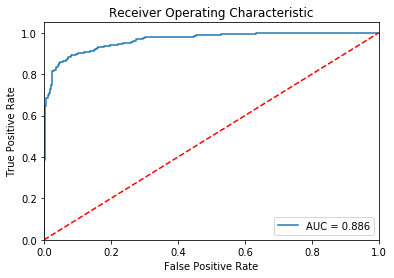

In [87]:
roc_auc = metrics.roc_auc_score(y_test, mnb.predict(X_test_dtm))
fpr, tpr, thresholds = metrics.roc_curve(y_test, mnb.predict_proba(X_test_dtm)[:, 1])

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.3f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Check the Predicted Probability for a Random Pelosi and Trump tweet

Below are provided a couple of tweets from both Pelosi and Trump.

Estimate the predicted probability of being Trump for the two tweets.

In [88]:
# Prep our source as Tfidf vectors
source_test = ["Welcome to the Capitol, @EP_President Antonio Tajani! https://t.co/YEEb7kFmXF",
               "It was not a campaign contribution, and there were no violations of the campaign finance laws by me. Fake News!"]

# NOTE:  Do not re-initialize the Tfidf vectorizor or the feature space will be overwritten and hence your transform 
#        will not match the number of features you trained your model on.
#
# This is why you only need to "transform" since you already "fit" previously.

# Transform documents to document-term matrix
X_test_dtm = vect.transform(source_test)

In [89]:
# Calculate predicted probability estimates of class membership
# Each row sums to one and contains the probabilities of the point being a 0-Pelosi, 1-Trump
mnb.predict_proba(X_test_dtm)

array([[0.69223854, 0.30776146],
       [0.07527659, 0.92472341]])

The 1st column is probability of being Pelosi, and the 2nd column of being Trump. The classifier is getting it right.